#### Fuzzy

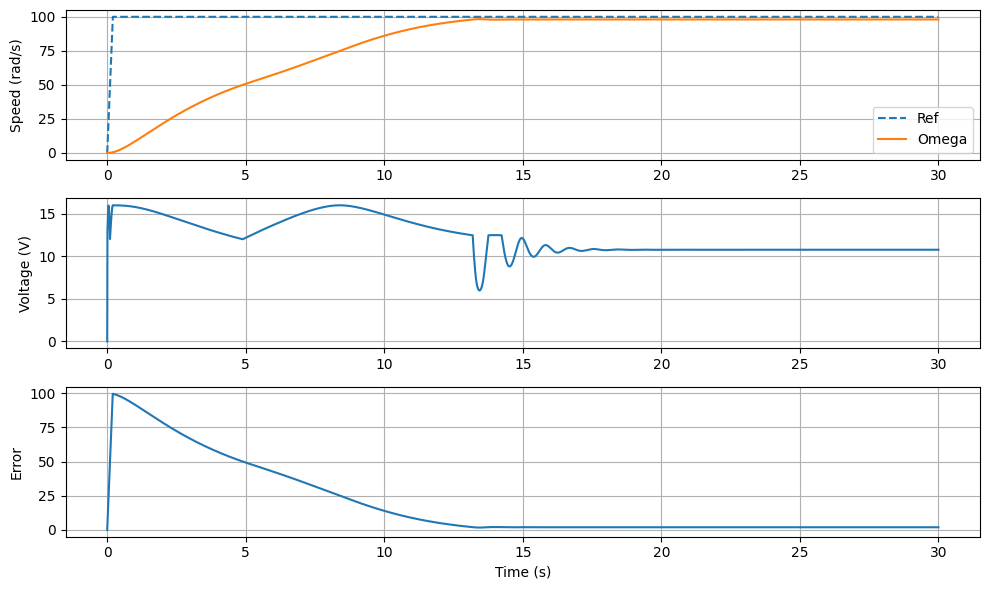

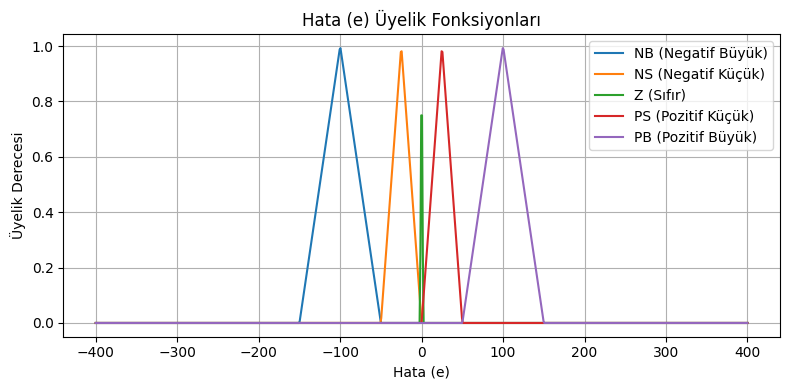

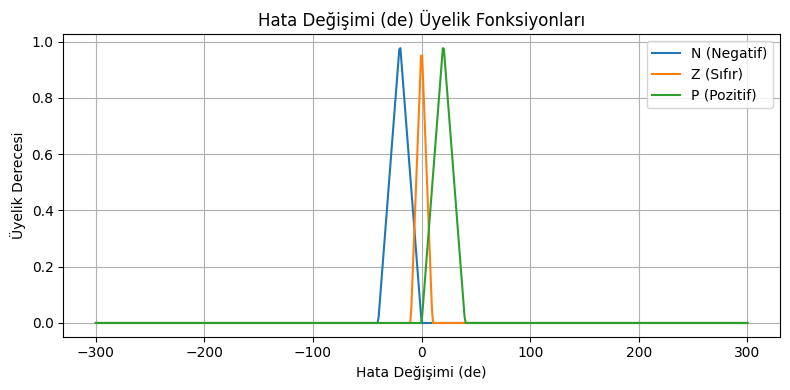

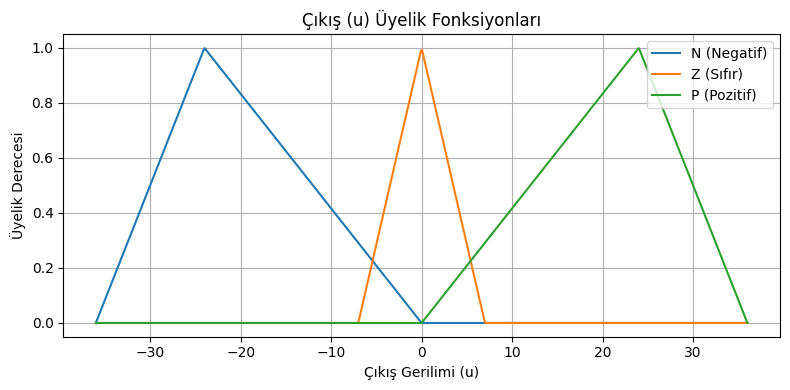

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# 1) DC Motor parametreleri
# ---------------------------
R = 1.0
L = 0.5
Kt = 0.01
Kb = 0.01
J = 0.01
B = 0.001
Vmax = 24.0

# ---------------------------
# 2) Üyelik fonksiyonları
# ---------------------------
def triangular(x, a, b, c):
    x = np.asarray(x)
    mu = np.zeros_like(x, dtype=float)
    left = (a < x) & (x <= b)
    mu[left] = (x[left] - a) / (b - a + 1e-12)
    right = (b < x) & (x < c)
    mu[right] = (c - x[right]) / (c - b + 1e-12)
    mu[x == b] = 1.0
    return mu

#e_Z (Error Zero): Hata Sıfır.Motorun hızı, hedef hıza çok yakın. Hata 0 civarında.

#e_PS (Error Positive Small): Hata Pozitif Küçük. Motorun hızı, hedefin biraz altında (örn: hata +15).

#e_PB (Error Positive Big): Hata Pozitif Büyük.Motorun hızı, hedefin çok altında (örn: hata +80).

#e_NS (Error Negative Small): Hata Negatif Küçük. Motorun hızı, hedefin biraz üstünde (örn: hata -15). Buna "Overshoot" denir.

#e_NB (Error Negative Big): Hata Negatif Büyük. Motorun hızı, hedefin çok üstünde (örn: hata -80).

#e_ ayarı hatayı küçültüyor

# --- Hata (e) için 5 üyelik fonksiyonu ---
#e_NB = (-400, -300, -200)
#e_NB = (-200, -150, -100)
e_NB = (-150, -100, -50)
#e_NS = (-300, -150, 0)
#e_NS = (-100, -50, 0)
e_NS = (-50, -25, 0)
#e_Z  = (-20, 0, 20)
e_Z = (-2, 0, 2)
#e_PS = (0, 150, 300)
#e_PS = (0, 50, 100)
e_PS = (0, 25, 50)
#e_PB = (200, 300, 400)
#e_PB = (100, 150, 200)
e_PB = (50, 100, 150)

#de_Z (Delta Error Zero): Hata Değişimi Sıfır. Hata değişmiyor. Motorun hızı sabitlendi (ya hedefte ya da yanlış bir yerde takılı kaldı).

#de_P (Delta Error Positive): Hata Değişimi Pozitif. Hata artıyor. Bu kötü, motor hedeften uzaklaşıyor demektir.

#de_N (Delta Error Negative): Hata Değişimi Negatif. Hata azalıyor. Bu iyi, motor hedefe yaklaşıyor demektir.

# --- Hata değişimi (de) için 3 üyelik fonksiyonu ---

#de_ ayarı hatanın nasıl değiştiğini doğru algılamasını sağlıyor.

#de_N, de_Z, de_P = (-300, -200, 0), (-50, 0, 50), (0, 200, 300)
de_N, de_Z, de_P = (-40, -20, 0), (-10, 0, 10), (0, 20, 40)

# --- Çıkış (u) üyelikleri ---
u_N, u_Z, u_P = (-Vmax*1.5, -Vmax, 0), (-7, 0, 7), (0, Vmax, Vmax*1.5)

# --- 5x3 kural tablosu (e x de) ---
# e: [NB, NS, Z, PS, PB]
# de: [N, Z, P]
    #['Z', 'P', 'P'],   # PS
rule_table = [
    ['N', 'N', 'N'],   # NB
    ['N', 'N', 'Z'],   # NS
    ['N', 'Z', 'P'],   # Z
    ['P', 'P', 'P'],   # PS
    ['P', 'P', 'P']    # PB
]

output_mfs = {'N': u_N, 'Z': u_Z, 'P': u_P}

# --- Fuzzification ---
def fuzzify_e_de(e, de):
    mu_e = {
        'NB': triangular([e], *e_NB)[0],
        'NS': triangular([e], *e_NS)[0],
        'Z':  triangular([e], *e_Z)[0],
        'PS': triangular([e], *e_PS)[0],
        'PB': triangular([e], *e_PB)[0],
    }
    mu_de = {'N': triangular([de], *de_N)[0], 'Z': triangular([de], *de_Z)[0], 'P': triangular([de], *de_P)[0]}
    return mu_e, mu_de

# --- Mamdani Defuzzification ---
def mamdani_defuzz(e, de, u_disc=np.linspace(-Vmax, Vmax, 1001)):
    mu_e, mu_de = fuzzify_e_de(e, de)
    aggregated = np.zeros_like(u_disc)
    e_labels = ['NB', 'NS', 'Z', 'PS', 'PB']
    de_labels = ['N', 'Z', 'P']

    #cıkarım yöntemi minimumdan maxa değiştirildi sonra motorun yavaşladığı tespit edildi (max-product)
    for i_e, e_lab in enumerate(e_labels):
        for j_de, de_lab in enumerate(de_labels):
            fire = min(mu_e[e_lab], mu_de[de_lab])
            if fire <= 0: continue
            a, b, c = output_mfs[rule_table[i_e][j_de]]
            mu_out = triangular(u_disc, a, b, c)
            aggregated = np.maximum(aggregated, np.minimum(mu_out, fire))

    num, den = np.sum(u_disc * aggregated), np.sum(aggregated)
    return 0.0 if den == 0 else np.clip(num/den, -Vmax, Vmax)

# ---------------------------
# 3) DC Motor dinamiği
# ---------------------------
def motor_derivatives(x, u, TL=0.0):
    i, w = x
    di = (-R*i - Kb*w + u)/L
    dw = (-B*w + Kt*i - TL)/J
    return np.array([di, dw])

def rk4_step(x, u, dt, TL=0.0):
    k1 = motor_derivatives(x, u, TL)
    k2 = motor_derivatives(x + 0.5*dt*k1, u, TL)
    k3 = motor_derivatives(x + 0.5*dt*k2, u, TL)
    k4 = motor_derivatives(x + dt*k3, u, TL)
    return x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# ---------------------------
# 4) Kapalı çevrim simülasyonu
# ---------------------------
def simulate(ref_func, T=5.0, dt=0.001, x0=None):
    if x0 is None: x = np.array([0.0, 0.0])
    else: x = np.array(x0, dtype=float)
    t = np.arange(0, T+dt, dt)
    N = len(t)
    i_hist, w_hist, u_hist, e_hist, ref_hist = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    prev_e = 0.0

    for k in range(N):
        ref = ref_func(t[k])
        e = ref - x[1]
        de = e - prev_e
        u = mamdani_defuzz(e, de)
        x = rk4_step(x, u, dt)
        i_hist[k], w_hist[k], u_hist[k], e_hist[k], ref_hist[k] = x[0], x[1], u, e, ref
        prev_e = e
    return t, w_hist, u_hist, e_hist, ref_hist

# ---------------------------
# 5) Örnek simülasyon
# ---------------------------
if __name__ == "__main__":
    ref_val = 100.0  # rad/s
    def ref(t):
        return ref_val * (t/0.2) if t < 0.2 else ref_val
    
    #t, w, u, e, ref_sig = simulate(ref, T=5.0, dt=0.001)

    t, w, u, e, ref_sig = simulate(ref, T=30.0, dt=0.001)

    plt.figure(figsize=(10,6))
    plt.subplot(3,1,1)
    plt.plot(t, ref_sig, '--', label='Ref')
    plt.plot(t, w, label='Omega')
    plt.ylabel('Speed (rad/s)'); plt.legend(); plt.grid(True)

    plt.subplot(3,1,2)
    plt.plot(t, u); plt.ylabel('Voltage (V)'); plt.grid(True)

    plt.subplot(3,1,3)
    plt.plot(t, e); plt.ylabel('Error'); plt.xlabel('Time (s)'); plt.grid(True)

    plt.tight_layout(); plt.show()


    # ============================================================
    # 6) TÜM ÜYELİK FONKSİYONLARININ GRAFİKLERİ
    # ============================================================

    # ---------------------------
    # a) Hata (e) üyelik fonksiyonları
    # ---------------------------
    e_vals = np.linspace(-400, 400, 800)
    mu_NB = triangular(e_vals, *e_NB)
    mu_NS = triangular(e_vals, *e_NS)
    mu_Z  = triangular(e_vals, *e_Z)
    mu_PS = triangular(e_vals, *e_PS)
    mu_PB = triangular(e_vals, *e_PB)

    plt.figure(figsize=(8,4))
    plt.plot(e_vals, mu_NB, label='NB (Negatif Büyük)')
    plt.plot(e_vals, mu_NS, label='NS (Negatif Küçük)')
    plt.plot(e_vals, mu_Z,  label='Z (Sıfır)')
    plt.plot(e_vals, mu_PS, label='PS (Pozitif Küçük)')
    plt.plot(e_vals, mu_PB, label='PB (Pozitif Büyük)')
    plt.title('Hata (e) Üyelik Fonksiyonları')
    plt.xlabel('Hata (e)')
    plt.ylabel('Üyelik Derecesi')
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------------------------
    # b) Hata değişimi (de) üyelik fonksiyonları
    # ---------------------------
    de_vals = np.linspace(-300, 300, 600)
    mu_de_N = triangular(de_vals, *de_N)
    mu_de_Z = triangular(de_vals, *de_Z)
    mu_de_P = triangular(de_vals, *de_P)

    plt.figure(figsize=(8,4))
    plt.plot(de_vals, mu_de_N, label='N (Negatif)')
    plt.plot(de_vals, mu_de_Z, label='Z (Sıfır)')
    plt.plot(de_vals, mu_de_P, label='P (Pozitif)')
    plt.title('Hata Değişimi (de) Üyelik Fonksiyonları')
    plt.xlabel('Hata Değişimi (de)')
    plt.ylabel('Üyelik Derecesi')
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------------------------
    # c) Çıkış (u) üyelik fonksiyonları
    # ---------------------------
    u_vals = np.linspace(-1.5*Vmax, 1.5*Vmax, 600)
    mu_u_N = triangular(u_vals, *u_N)
    mu_u_Z = triangular(u_vals, *u_Z)
    mu_u_P = triangular(u_vals, *u_P)

    plt.figure(figsize=(8,4))
    plt.plot(u_vals, mu_u_N, label='N (Negatif)')
    plt.plot(u_vals, mu_u_Z, label='Z (Sıfır)')
    plt.plot(u_vals, mu_u_P, label='P (Pozitif)')
    plt.title('Çıkış (u) Üyelik Fonksiyonları')
    plt.xlabel('Çıkış Gerilimi (u)')
    plt.ylabel('Üyelik Derecesi')
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()
